In [ ]:
# notebook by Steffen Finck, 2023
# for course: Elective Artificial Intelligence, Informatics Digital Innovation

In [1]:
# required modules
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# optional modules
import nltk
import string
#nltk.download('punkt') # only required for the first time
#nltk.download('averaged_perceptron_tagger') # only required for the first time
#nltk.download('stopwords') # only required for the first time

In [2]:
nrows = None # can be used to only load a fixed number of observations

# read train data set
df_train = pd.read_csv('Genre Classification Dataset/train_data.txt', sep=':::',\
                       engine='python', header=None, nrows=nrows)
df_train.rename(columns={0:'id', 1:'title', 2:'genre', 3:'description'}, inplace=True)
display(df_train.head())

# read test data set
df_test = pd.read_csv('Genre Classification Dataset/test_data_solution.txt', sep=':::',\
                       engine='python', header=None, nrows=nrows)
df_test.rename(columns={0:'id', 1:'title', 2:'genre', 3:'description'}, inplace=True)
display(df_test.head())

,id,title,genre,description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


,id,title,genre,description
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           54214 non-null  int64 
 1   title        54214 non-null  object
 2   genre        54214 non-null  object
 3   description  54214 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [4]:
df_train.loc[0,'description']

' Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone except straight-talking Rose, the lady in pink he meets on the hospital stairs. As Christmas approaches, Rose uses her fantastical experiences as a professional wrestler, her imagination, wit and charm to allow Oscar to live life and love to the full, in the company of his friends Pop Corn, Einstein, Bacon and childhood sweetheart Peggy Blue.'

,train,test
action,1315,1314
adult,590,590
adventure,775,775
animation,498,498
biography,265,264
comedy,7447,7446
crime,505,505
documentary,13096,13096
drama,13613,13612
family,784,783


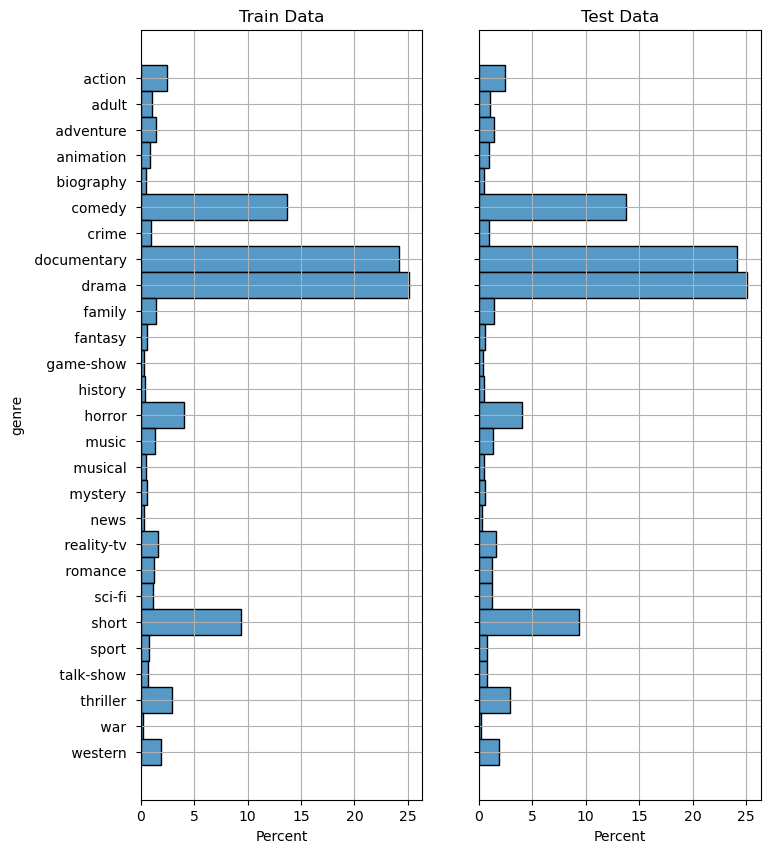

Common titles used in both datasets:
set()


In [5]:
# compare genre distribution
genres = pd.DataFrame(columns=['train', 'test'], index=df_train['genre'].sort_values().unique())
gtrain = df_train['genre'].value_counts().sort_index()
gtest = df_test['genre'].value_counts().sort_index()
genres['train'] = gtrain
genres['test'] = gtest
display(genres)
fig, axs = plt.subplots(1,2, figsize=(8,10), sharey=True)
seaborn.histplot(data=df_train.sort_values('genre'), y='genre', ax=axs[0], stat='percent', discrete=True)
seaborn.histplot(data=df_test.sort_values('genre'), y='genre', ax=axs[1], stat='percent', discrete=True)
axs[0].set_title('Train Data')
axs[0].grid()
axs[1].set_title('Test Data')
axs[1].grid()
plt.show()

# test data in train data?
titlesTest = set(df_test['title'])
titlesTrain = set(df_train['title'])
print('Common titles used in both datasets:')
print(titlesTest.intersection(titlesTrain))

summary statics for length of train descriptions


count    54214.0
mean       600.0
std        446.0
min         42.0
25%        325.0
50%        464.0
75%        713.0
max      10504.0
Name: description, dtype: float64

summary statics for length of test descriptions


count    54200.0
mean       601.0
std        438.0
min         38.0
25%        325.0
50%        464.0
75%        709.0
max       9084.0
Name: description, dtype: float64

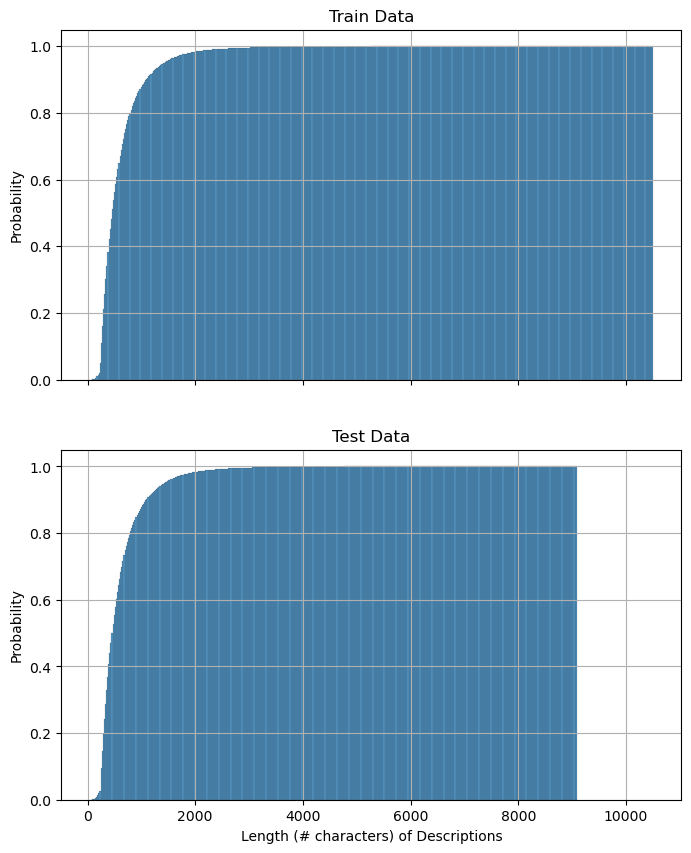

In [6]:
# length of descriptions
ltrain = df_train['description'].apply(lambda x: len(x))
ltest = df_test['description'].apply(lambda x: len(x))

print('summary statics for length of train descriptions')
display(ltrain.describe().round(0))
print('summary statics for length of test descriptions')
display(ltest.describe().round(0))

fig, axs = plt.subplots(2,1, figsize=(8,10), sharex=True)
seaborn.histplot(x=ltrain, ax=axs[0], stat='probability', cumulative=True)
seaborn.histplot(x=ltest, ax=axs[1], stat='probability', cumulative=True)
axs[0].set_title('Train Data')
axs[0].grid()
axs[1].set_title('Test Data')
axs[1].set_xlabel('Length (# characters) of Descriptions')
axs[1].grid()
plt.show()

In [7]:
# let us do random assignments - how good are we?
rng = np.random.default_rng(seed=42)
# lets do it several times
samplesize = 10000
for i in range(5):
    # draw random labels from training set
    guesses = rng.choice(df_train['genre'],size=samplesize, replace=True)
    # draw random labels from test set
    samples = rng.choice(df_test['genre'],size=samplesize)
    print(classification_report(samples, guesses, digits=4))

               precision    recall  f1-score   support

      action      0.0310    0.0376    0.0340       213
       adult      0.0085    0.0091    0.0088       110
   adventure      0.0144    0.0146    0.0145       137
   animation      0.0000    0.0000    0.0000       100
   biography      0.0000    0.0000    0.0000        47
      comedy      0.1291    0.1252    0.1271      1382
       crime      0.0103    0.0103    0.0103        97
 documentary      0.2285    0.2302    0.2294      2407
       drama      0.2372    0.2361    0.2367      2541
      family      0.0147    0.0120    0.0132       167
     fantasy      0.0000    0.0000    0.0000        65
   game-show      0.0000    0.0000    0.0000        34
     history      0.0323    0.0152    0.0206        66
      horror      0.0484    0.0495    0.0490       404
       music      0.0075    0.0079    0.0077       127
     musical      0.0182    0.0189    0.0185        53
     mystery      0.0175    0.0169    0.0172        59
        n

In [8]:
# to make life easier, we transform all descriptions into lower case and strip all leading and trailing white spaces
df_train['description'] = df_train['description'].apply(lambda x: x.lower().strip())
df_train['genre'] = df_train['genre'].apply(lambda x: x.lower().strip())
df_test['description'] = df_test['description'].apply(lambda x: x.lower().strip())
df_test['genre'] = df_train['genre'].apply(lambda x: x.lower().strip())

# Then we tokenize the descriptions. first Idea: split into single words
df_train['tokens'] =  df_train['description'].apply(lambda x:nltk.tokenize.word_tokenize(x, language='english',\
                                                                                         preserve_line=False))
df_test['tokens'] =  df_test['description'].apply(lambda x:nltk.tokenize.word_tokenize(x, language='english',\
                                                                                       preserve_line=False))

In [9]:
display(df_train.loc[0, 'description'])
display(df_train.loc[0, 'tokens'])

'listening in to a conversation between his doctor and parents, 10-year-old oscar learns what nobody has the courage to tell him. he only has a few weeks to live. furious, he refuses to speak to anyone except straight-talking rose, the lady in pink he meets on the hospital stairs. as christmas approaches, rose uses her fantastical experiences as a professional wrestler, her imagination, wit and charm to allow oscar to live life and love to the full, in the company of his friends pop corn, einstein, bacon and childhood sweetheart peggy blue.'

['listening',
 'in',
 'to',
 'a',
 'conversation',
 'between',
 'his',
 'doctor',
 'and',
 'parents',
 ',',
 '10-year-old',
 'oscar',
 'learns',
 'what',
 'nobody',
 'has',
 'the',
 'courage',
 'to',
 'tell',
 'him',
 '.',
 'he',
 'only',
 'has',
 'a',
 'few',
 'weeks',
 'to',
 'live',
 '.',
 'furious',
 ',',
 'he',
 'refuses',
 'to',
 'speak',
 'to',
 'anyone',
 'except',
 'straight-talking',
 'rose',
 ',',
 'the',
 'lady',
 'in',
 'pink',
 'he',
 'meets',
 'on',
 'the',
 'hospital',
 'stairs',
 '.',
 'as',
 'christmas',
 'approaches',
 ',',
 'rose',
 'uses',
 'her',
 'fantastical',
 'experiences',
 'as',
 'a',
 'professional',
 'wrestler',
 ',',
 'her',
 'imagination',
 ',',
 'wit',
 'and',
 'charm',
 'to',
 'allow',
 'oscar',
 'to',
 'live',
 'life',
 'and',
 'love',
 'to',
 'the',
 'full',
 ',',
 'in',
 'the',
 'company',
 'of',
 'his',
 'friends',
 'pop',
 'corn',
 ',',
 'einstein',
 ',',
 'bacon',
 'and',
 'childhood',
 'sweetheart',
 'peggy',
 'blue',
 '.']

In [10]:
# what are the most frequent words?
nSigWords = 20
# use all tokens
fulllist = list()
for l in df_train['tokens'].to_list():
    fulllist.extend(w for w in l)
words, counts = np.unique(fulllist, return_counts=True)
nWords = len(fulllist)
print('total number of words: {}'.format(nWords))
# argsort sort from smallest to largest
for j,ids in enumerate(np.argsort(counts)[::-1]):
    print('word: {0}  absolute count: {1}  frequency: {2:.4f}'.format(words[ids], counts[ids], counts[ids]/nWords))
    if j == nSigWords-1:
        break

total number of words: 6275781
word: the  absolute count: 333793  frequency: 0.0532
word: ,  absolute count: 310018  frequency: 0.0494
word: .  absolute count: 248697  frequency: 0.0396
word: and  absolute count: 190634  frequency: 0.0304
word: a  absolute count: 175928  frequency: 0.0280
word: of  absolute count: 167220  frequency: 0.0266
word: to  absolute count: 158834  frequency: 0.0253
word: in  absolute count: 108715  frequency: 0.0173
word: is  absolute count: 83270  frequency: 0.0133
word: his  absolute count: 67668  frequency: 0.0108
word: 's  absolute count: 53265  frequency: 0.0085
word: with  absolute count: 52633  frequency: 0.0084
word: her  absolute count: 46967  frequency: 0.0075
word: he  absolute count: 45242  frequency: 0.0072
word: for  absolute count: 41771  frequency: 0.0067
word: that  absolute count: 41142  frequency: 0.0066
word: on  absolute count: 36877  frequency: 0.0059
word: as  absolute count: 35275  frequency: 0.0056
word: their  absolute count: 32370  f

In [11]:
# remove punctuation and stopwords
sw = nltk.corpus.stopwords.words('english')
sw.append("'s")
sw.append("''")
sw.append("``")
sw.append('...')
sw.append('n\'t')
newfulllist = [w for w in fulllist if (w not in sw) and (w not in string.punctuation)]
words, counts = np.unique(newfulllist, return_counts=True)
nWords = len(newfulllist)
print('total number of words: {}'.format(nWords))
# argsort sort from smallest to largest
for j,ids in enumerate(np.argsort(counts)[::-1]):
    print('word: {0}  absolute count: {1}  frequency: {2:.4f}'.format(words[ids], counts[ids], counts[ids]/nWords))
    if j == nSigWords-1:
        break

total number of words: 3109860
word: life  absolute count: 17511  frequency: 0.0056
word: one  absolute count: 16945  frequency: 0.0054
word: film  absolute count: 13278  frequency: 0.0043
word: new  absolute count: 11507  frequency: 0.0037
word: world  absolute count: 11231  frequency: 0.0036
word: young  absolute count: 10099  frequency: 0.0032
word: story  absolute count: 10077  frequency: 0.0032
word: family  absolute count: 9626  frequency: 0.0031
word: two  absolute count: 9490  frequency: 0.0031
word: love  absolute count: 9154  frequency: 0.0029
word: man  absolute count: 9065  frequency: 0.0029
word: time  absolute count: 8586  frequency: 0.0028
word: years  absolute count: 8139  frequency: 0.0026
word: people  absolute count: 8089  frequency: 0.0026
word: father  absolute count: 6820  frequency: 0.0022
word: find  absolute count: 6621  frequency: 0.0021
word: first  absolute count: 6582  frequency: 0.0021
word: get  absolute count: 6514  frequency: 0.0021
word: lives  absolut

In [12]:
mostFrequent = pd.DataFrame(index=list(set(df_train['genre'])),\
                            columns=['word '+str(i) for i in range(1,nSigWords+1)])
for g, df in df_train.groupby('genre'):
    genrelist = list()
    for l in df['tokens'].to_list():
        genrelist.extend(w for w in l if (w not in sw) and (w not in string.punctuation))
    words, counts = np.unique(genrelist, return_counts=True)
    nWords = len(genrelist)
    print('total number of words in {1}: {0}'.format(nWords,g))
    for j,ids in enumerate(np.argsort(counts)[::-1]):
        mostFrequent.loc[g, 'word '+str(j+1)] = words[ids]
        if j == nSigWords-1:
            break
display(mostFrequent)

total number of words in action: 73251
total number of words in adult: 27911
total number of words in adventure: 40641
total number of words in animation: 25964
total number of words in biography: 16222
total number of words in comedy: 403227
total number of words in crime: 27239
total number of words in documentary: 812324
total number of words in drama: 813831
total number of words in family: 44393
total number of words in fantasy: 17749
total number of words in game-show: 14508
total number of words in history: 13986
total number of words in horror: 126467
total number of words in music: 41482
total number of words in musical: 15624
total number of words in mystery: 19783
total number of words in news: 8804
total number of words in reality-tv: 45930
total number of words in romance: 41044
total number of words in sci-fi: 33947
total number of words in short: 234953
total number of words in sport: 25002
total number of words in talk-show: 19472
total number of words in thriller: 8732

,word 1,word 2,word 3,word 4,word 5,word 6,word 7,word 8,word 9,word 10,word 11,word 12,word 13,word 14,word 15,word 16,word 17,word 18,word 19,word 20
history,history,story,war,world,film,one,years,new,young,time,first,people,american,life,two,century,men,family,documentary,many
game-show,show,game,one,team,answer,contestants,contestant,questions,question,three,two,round,would,win,prize,money,teams,first,cash,answers
adult,sex,two,one,young,girls,sexual,woman,women,get,new,first,gets,bound,gagged,hot,time,story,three,man,scene
drama,life,one,young,love,family,father,story,man,mother,two,new,son,lives,film,years,wife,woman,time,home,world
fantasy,world,one,story,life,time,new,young,find,love,man,evil,power,years,girl,finds,must,day,land,two,magic
musical,musical,music,love,new,one,film,story,young,world,show,girl,life,time,dance,song,singer,father,people,get,man
animation,world,one,friends,new,life,help,story,time,series,day,young,evil,boy,little,find,children,way,adventures,save,family
adventure,one,world,story,find,two,life,new,young,time,father,man,adventure,game,first,way,must,take,people,bondage,love
news,news,new,show,series,film,one,tv,world,program,first,viewers,also,people,interviews,television,hosted,us,qv,issues,life
thriller,one,life,man,young,find,new,wife,two,family,world,finds,police,murder,story,killer,time,get,woman,father,death


In [13]:
df_test.loc[0,'description']

"l.r. brane loves his life - his car, his apartment, his job, but especially his girlfriend, vespa. one day while showering, vespa runs out of shampoo. l.r. runs across the street to a convenience store to buy some more, a quick trip of no more than a few minutes. when he returns, vespa is gone and every trace of her existence has been wiped out. l.r.'s life becomes a tortured existence as one strange event after another occurs to confirm in his mind that a conspiracy is working against his finding vespa."

In [14]:
df_test.loc[0, 'tokens']

['l.r',
 '.',
 'brane',
 'loves',
 'his',
 'life',
 '-',
 'his',
 'car',
 ',',
 'his',
 'apartment',
 ',',
 'his',
 'job',
 ',',
 'but',
 'especially',
 'his',
 'girlfriend',
 ',',
 'vespa',
 '.',
 'one',
 'day',
 'while',
 'showering',
 ',',
 'vespa',
 'runs',
 'out',
 'of',
 'shampoo',
 '.',
 'l.r',
 '.',
 'runs',
 'across',
 'the',
 'street',
 'to',
 'a',
 'convenience',
 'store',
 'to',
 'buy',
 'some',
 'more',
 ',',
 'a',
 'quick',
 'trip',
 'of',
 'no',
 'more',
 'than',
 'a',
 'few',
 'minutes',
 '.',
 'when',
 'he',
 'returns',
 ',',
 'vespa',
 'is',
 'gone',
 'and',
 'every',
 'trace',
 'of',
 'her',
 'existence',
 'has',
 'been',
 'wiped',
 'out',
 '.',
 'l.r',
 '.',
 "'s",
 'life',
 'becomes',
 'a',
 'tortured',
 'existence',
 'as',
 'one',
 'strange',
 'event',
 'after',
 'another',
 'occurs',
 'to',
 'confirm',
 'in',
 'his',
 'mind',
 'that',
 'a',
 'conspiracy',
 'is',
 'working',
 'against',
 'his',
 'finding',
 'vespa',
 '.']

In [15]:
# check the number of words which are in the most frequent set and the test set
[w for w in df_test.loc[0,'tokens'] if w in mostFrequent.loc['news'].values]

['life', 'one', 'life', 'one']

In [16]:
for genre in mostFrequent.index:
    agreement = [w for w in df_test.loc[0,'tokens'] if w in mostFrequent.loc[genre].values]
    print('genre: {0}, number of unique entries: {1}'.format(genre, len(agreement)))

genre: history, number of unique entries: 4
genre: game-show, number of unique entries: 2
genre: adult, number of unique entries: 2
genre: drama, number of unique entries: 4
genre: fantasy, number of unique entries: 5
genre: musical, number of unique entries: 4
genre: animation, number of unique entries: 5
genre: adventure, number of unique entries: 4
genre: news, number of unique entries: 4
genre: thriller, number of unique entries: 4
genre: mystery, number of unique entries: 4
genre: sci-fi, number of unique entries: 4
genre: romance, number of unique entries: 5
genre: action, number of unique entries: 4
genre: comedy, number of unique entries: 4
genre: western, number of unique entries: 2
genre: war, number of unique entries: 4
genre: family, number of unique entries: 4
genre: sport, number of unique entries: 3
genre: music, number of unique entries: 2
genre: crime, number of unique entries: 4
genre: short, number of unique entries: 5
genre: horror, number of unique entries: 4
genre

In [17]:
# check the test data
df_test.loc[0]

id                                                             1
title                                      Edgar's Lunch (1998) 
genre                                                      drama
description    l.r. brane loves his life - his car, his apart...
tokens         [l.r, ., brane, loves, his, life, -, his, car,...
Name: 0, dtype: object

In [18]:
predict = list()
uniqueMatches = 0
rng = np.random.default_rng(seed=28)
for j, row in df_test.iterrows():
    choices = list()
    maxAgree = -1
    for genre in mostFrequent.index:
        # this is faster
        agreement = len(set(row['tokens']).intersection(mostFrequent.loc[genre]))
        # check for agreements
        if agreement > maxAgree:
            choices = [genre]
            maxAgree = agreement
        elif agreement == maxAgree:
            choices.append(genre)
        else:
            pass
    # make a prediction
    if len(choices) > 0:
        pred = rng.choice(choices, size=1)
    else:
        # random choices from all genres
        pred = rng.choice(mostFrequent.index, size=1)
    predict.append(pred)
    if len(choices) == 1:
        uniqueMatches += choices[0] == row['genre']
print(classification_report(df_test['genre'], predict, digits=4))
print('unique matches: {0}'.format(uniqueMatches))

              precision    recall  f1-score   support

      action     0.0351    0.0479    0.0405      1315
       adult     0.0144    0.0373    0.0207       590
   adventure     0.0167    0.0361    0.0228       775
   animation     0.0109    0.0382    0.0170       498
   biography     0.0038    0.0415    0.0070       265
      comedy     0.1394    0.0540    0.0778      7445
       crime     0.0054    0.0119    0.0074       505
 documentary     0.2453    0.0868    0.1282     13093
       drama     0.2446    0.0735    0.1131     13611
      family     0.0163    0.0421    0.0235       783
     fantasy     0.0064    0.0311    0.0106       322
   game-show     0.0030    0.0103    0.0046       194
     history     0.0056    0.0661    0.0102       242
      horror     0.0406    0.0499    0.0448      2203
       music     0.0110    0.0192    0.0140       730
     musical     0.0060    0.0289    0.0099       277
     mystery     0.0027    0.0125    0.0045       319
        news     0.0028    